<a href="https://colab.research.google.com/github/daj10/Skin-Cancer-Segmentation-ISIC2018/blob/main/segmentation_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Skin Cancer Segmentation:** ***Melanoma Detection***

> Task 1: Lesion Segmentation, featuring image contour detection

> Task 2: Lesion Attribute Detection, featuring semantic image segmentation


[Data source: ISIC 2018](https://challenge.isic-archive.com/data#2018)





In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/'My Drive'/Reconnaissance-Formes

/content/drive/My Drive/Reconnaissance-Formes


## **Import Librairies**

In [3]:
import sys
import os
import cv2
import numpy as np
from scipy import ndimage

############################

import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from scipy import ndimage
from scipy import misc
from skimage import exposure
#for group normalization
sys.path.append('/content/drive/MyDrive/Reconnaissance-Formes/Keras-Group-Normalization-master') 
from group_norm import GroupNormalization

## **Data Pre-processing**

> store numpy array of images



### Training Data

In [4]:
from glob import glob
import time

IMAGES = glob('/content/drive/MyDrive/Reconnaissance-Formes/ISIC2018/Train/images/*.jpg') #directory of original images
MASKS = glob('/content/drive/MyDrive/Reconnaissance-Formes/ISIC2018/Train/masks/*.png') #directory of mask images

In [5]:
# Test if every images have its mask
i = 0
t1 = time.time()
for elt, elt2 in zip(sorted(IMAGES), sorted(MASKS)):
    if (os.path.splitext(os.path.split(elt)[1])[0]).split("_")[1] == (os.path.splitext(os.path.split(elt2)[1])[0]).split("_")[1]:
      i+=1
print(i)
t2 = time.time()
t = t2 - t1
print("excecution time:", t)
print(sorted(IMAGES)[1000])
print(sorted(MASKS)[1000])

1500
excecution time: 0.01936650276184082
/content/drive/MyDrive/Reconnaissance-Formes/ISIC2018/Train/images/ISIC_0010847.jpg
/content/drive/MyDrive/Reconnaissance-Formes/ISIC2018/Train/masks/ISIC_0010847_segmentation.png


In [6]:
X = [] #skin cancer image
y = [] #mask of skin cancer

IMG_SIZE = 256 # size of image
height = 256
width = 256

def train_data(IMAGES, MASKS):
  '''
  function to store numpy array of train images
  input: images and corresponding ground truth response masks.
  '''
  # Images
  for img in sorted(IMAGES):
    img_arr=cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    img_arr = cv2.resize(img_arr, (width, height))
    #img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            
    #gaussian blur
    img_arr = ndimage.gaussian_filter(img_arr, sigma=1)
            
    #contrast stretching
    f_max = (np.amax(img_arr))
    f_min = (np.amin(img_arr))
    img_arr = ((img_arr - f_min)/(f_max - f_min))*255
            
    #sharpen
    filter_blurred_f = ndimage.gaussian_filter(img_arr, sigma=1)
    alpha = 10
    img_arr = img_arr + alpha * (img_arr -filter_blurred_f)
            
    new_arr = img_arr/255.0
    X.append(new_arr)

  # Masks  
  for img in sorted(MASKS):
    truth_img_arr = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    truth_new_arr = cv2.resize(truth_img_arr, (height, width))
    truth_new_arr = truth_new_arr/255.0
    y.append(truth_new_arr)


train_data(IMAGES, MASKS)


HEIGHT = 256
WIDTH = 256
X = np.array(X).reshape(-1, WIDTH, HEIGHT, 1)
y = np.array(y).reshape(-1, WIDTH, HEIGHT, 1)
print("Data Train shape: ", X.shape)
print("Data Train Mask", y.shape)

#save numpy array of train images mask
np.save('/content/drive/MyDrive/Reconnaissance-Formes/ISIC2018/Train/Train_img.npy', X)
np.save('/content/drive/MyDrive/Reconnaissance-Formes/ISIC2018/Train/Train_mask.npy', y)

Data Train shape:  (1500, 256, 256, 1)
Data Train Mask (1500, 256, 256, 1)


### Test data

In [8]:
X_test = []
DATA_TEST = "/content/drive/MyDrive/Reconnaissance-Formes/ISIC2018/Test"
def create_test_data(DATA_TEST):
    
    height = 256
    width = 256
    for img in os.listdir(DATA_TEST):
          img_arr=cv2.imread(os.path.join(DATA_TEST, img), cv2.IMREAD_GRAYSCALE)
          img_arr = cv2.resize(img_arr, (width, height))
            
          #gaussian blur
          img_arr = ndimage.gaussian_filter(img_arr, sigma=1)
            
          #contrast stretching
          f_max = (np.amax(img_arr))
          f_min = (np.amin(img_arr))
          img_arr = ((img_arr - f_min)/(f_max - f_min))*255
            
          #sharpen
          filter_blurred_f = ndimage.gaussian_filter(img_arr, 2)
          alpha = 10
          img_arr = img_arr + alpha * (img_arr -filter_blurred_f)
            
            
          new_arr = img_arr/255.0
          X_test.append(new_arr)

create_test_data(DATA_TEST)

In [9]:
height = 256
width = 256

X_test = np.array(X_test).reshape(-1, width, height, 1)
print(X_test.shape)

np.save('/content/drive/MyDrive/Reconnaissance-Formes/ISIC2018/Test_Skin.npy', X_test)

(1000, 256, 256, 1)


## **Load Data saved**

In [4]:
# Train Images
X = np.load("/content/drive/MyDrive/Reconnaissance-Formes/ISIC2018/Train/Train_img.npy")

# Train Mask
y = np.load("/content/drive/MyDrive/Reconnaissance-Formes/ISIC2018/Train/Train_mask.npy")

# Test Images
X_test = np.load("/content/drive/MyDrive/Reconnaissance-Formes/ISIC2018/Test_Skin.npy")


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

## **Split train and validation**

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 123)

### Check if training data looks all right

Text(0.5, 1.0, 'mask')

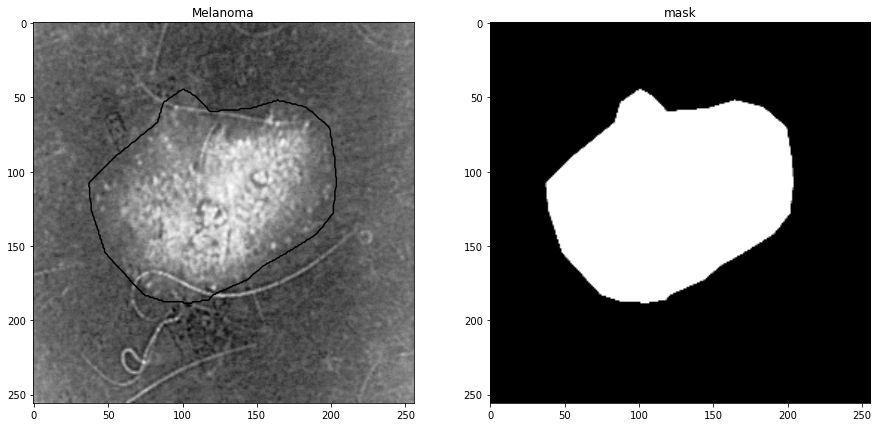

In [37]:
import random

ix = 0 #random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(15, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='Greys', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Melanoma')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('mask')


## **Data Generator**


> Nous organiserons notre ensemble de données sur disque afin de pouvoir utiliser la classe ImageDataGenerator de Keras pour générer des lots d'images à partir du disque sans avoir à conserver l'ensemble de données en mémoire.

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(horizontal_flip = True, 
                     vertical_flip = True, 
                     rotation_range = 180, 
                     width_shift_range = 0.1, 
                     height_shift_range = 0.1)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 613 # Il est important d'utiliser la même graine pour les deux générateurs
bs = 16

image_generator = image_datagen.flow(X_train, seed=seed, batch_size=bs, shuffle=True)
mask_generator = mask_datagen.flow(y_train, seed=seed, batch_size=bs, shuffle=True)

# Just zip the two generators to get a generator that provides augmented images and masks at the same time
train_generator = zip(image_generator, mask_generator)

## **Build model**

### Modele 1



> Dense prediction: Semantic image segmentation : Label each pixel of an image with a corresponding class of what is being represented.

> pixel-level image classification.






In [40]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from scipy import ndimage
from scipy import misc
from skimage import exposure


In [41]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 1

In [42]:
def unet(input_size = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)):
    inputs = Input(input_size)
    
    
    G=32
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    #3x3 matric on i'inputs' - 2 times
    bn1=GroupNormalization(groups=G)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)
    #Pooling - 2x2 matrix applied on conv1

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    #3x3 matric on pooled data 
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    bn2=GroupNormalization(groups=G)(conv2)
    #3x3 matrix on convolution applied on pooled data
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)
    #Pooling - 2x2 matrix applied on conv2
    
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    #3x3 matric on pooled data
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    bn3=GroupNormalization(groups=G)(conv3)
    #3x3 matrix on convolution applied on pooled data
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)
    #Pooling - 2x2 matrix applied on conv3

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    bn4=GroupNormalization(groups=G)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)
    
    

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', dilation_rate=1)(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', dilation_rate=2)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', dilation_rate=4)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', dilation_rate=8)(conv5)


    bn5=GroupNormalization(groups=G)(conv5)
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn5), bn4], axis=3)
    #up convulation aaplied on conv5 (512 pixels) which is to be superimposed with conv 4 (256 pixels) using 2x2 matrix
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    #3x3 matrix on up6 - convert to 256 pixels
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    bn6=GroupNormalization(groups=G)(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn6), bn3], axis=3)
    #up convulation aaplied on conv6 (256 pixels) which is to be superimposed with conv3 (128 pixels) 
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    #3x3 matrix on up6 - convert to 128 pixels
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    bn7=GroupNormalization(groups=G)(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn7), bn2], axis=3)
    #up convulation aaplied on conv7 (128 pixels) which is to be superimposed with conv2 (64 pixels)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    #3x3 matrix on up6 - convert to 64 pixels
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    bn8=GroupNormalization(groups=G)(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(bn8), bn1], axis=3)
    #up convulation aaplied on conv8 (64 pixels) which is to be superimposed with conv1 (32 pixels)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    #3x3 matrix on up6 - convert to 32 pixels
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    bn9=GroupNormalization(groups=G)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)
    #conv9 converted to the image of original size under sigmoid activation by 1x1 matrix. The matrix is named conv10

    model = Model(inputs = inputs, outputs = conv10)
    
    return model

In [43]:
model = unet(input_size = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))

## **Metrics**

> Jaccard distance

> sensitivity

> specificity






In [44]:
from keras import backend as K
import tensorflow as tf 

In [45]:
def jaccard_distance(y_true, y_pred):
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection) / (sum_ - intersection)
    return tf.reduce_mean(jac)


def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [46]:
model.compile(optimizer = Adam(lr = 1e-4), loss="binary_crossentropy", metrics = ['accuracy', jaccard_distance, sensitivity, specificity])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
group_normalization (GroupNorma (None, 256, 256, 32) 64          conv2d_1[0][0]                   
______________________________________________________________________________________________

In [47]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [48]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model_training_file.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [49]:
results = model.fit(X_train, y_train, batch_size=16, epochs=100, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
75/75 [==============================] - 91s 972ms/step - loss: 0.4280 - accuracy: 0.8124 - jaccard_distance: 0.2468 - sensitivity: 0.3520 - specificity: 0.9558 - val_loss: 0.2681 - val_accuracy: 0.8997 - val_jaccard_distance: 0.4928 - val_sensitivity: 0.6440 - val_specificity: 0.9896

Epoch 00001: val_loss improved from inf to 0.26807, saving model to model_training_file.hdf5
Epoch 2/100
75/75 [==============================] - 70s 938ms/step - loss: 0.2555 - accuracy: 0.9046 - jaccard_distance: 0.4569 - sensitivity: 0.6858 - specificity: 0.9690 - val_loss: 0.1941 - val_accuracy: 0.9251 - val_jaccard_distance: 0.5622 - val_sensitivity: 0.7714 - val_specificity: 0.9796

Epoch 00002: val_loss improved from 0.26807 to 0.19411, saving model to model_training_file.hdf5
Epoch 3/100
75/75 [==============================] - 71s 941ms/step - loss: 0.2074 - accuracy: 0.9227 - jaccard_distance: 0.5391 - sensitivity: 0.7678 - specificity: 0.9723 - val_loss: 0.1797 - val_accuracy: 0.92

## **Results : Learning curve**

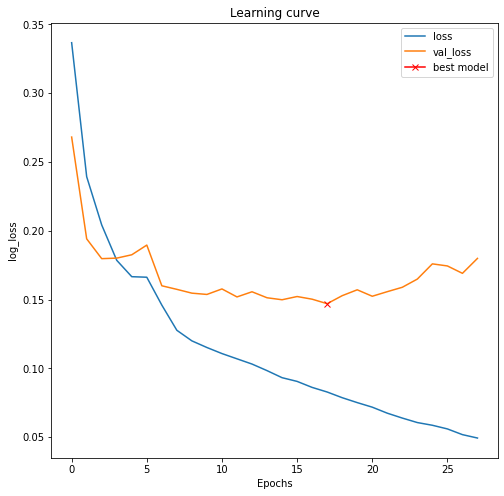

In [50]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

## **Load best model**

In [51]:
model.load_weights('model_training_file.hdf5')

## **Model testing and visualization**

Predicted mask shape::  (1, 256, 256, 1)


Text(0.5, 1.0, 'Target Truth')

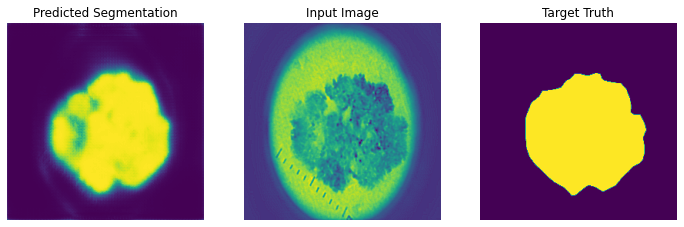

In [61]:
# Make prediction 
selecting_index = 200
prediction_input = np.expand_dims(X_valid[selecting_index], axis=0) # testing input
# Model predict
predict_img = model.predict(prediction_input)

# Note:: Keras model will predict output with shape of n x height x width x channel
print('Predicted mask shape:: ', predict_img.shape)

fig, axs = plt.subplots(1,3, figsize=(12,7))
axs[0].imshow(np.squeeze(predict_img))
axs[0].axis('off')
axs[0].set_title('Predicted Segmentation')
axs[1].imshow(np.squeeze(X_valid[selecting_index]))
axs[1].axis('off')
axs[1].set_title('Input Image')
axs[2].imshow(np.squeeze(y_valid[selecting_index]))
axs[2].axis('off')
axs[2].set_title('Target Truth')

## **Evaluate on validation set**

In [62]:
model.evaluate(X_valid, y_valid, verbose=1)

10/10 [==============================] - 9s 416ms/step - loss: 0.1470 - accuracy: 0.9461 - jaccard_distance: 0.7231 - sensitivity: 0.8783 - specificity: 0.9704


[0.14698536694049835,
 0.9461104273796082,
 0.7231217622756958,
 0.8783115148544312,
 0.9703859090805054]

## **Prediction on Train, Validation, Test set**

In [64]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)


# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

10/10 [==============================] - 4s 458ms/step


In [70]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='Greys')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Melanoma')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Tumor')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Tumor Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Tumor Predicted binary')

### **Prediction on Train set**

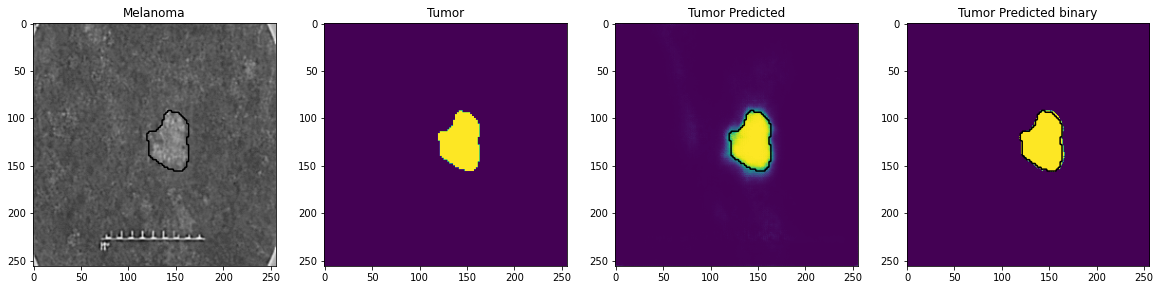

In [72]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=40)

### **Prediction on Validation set**

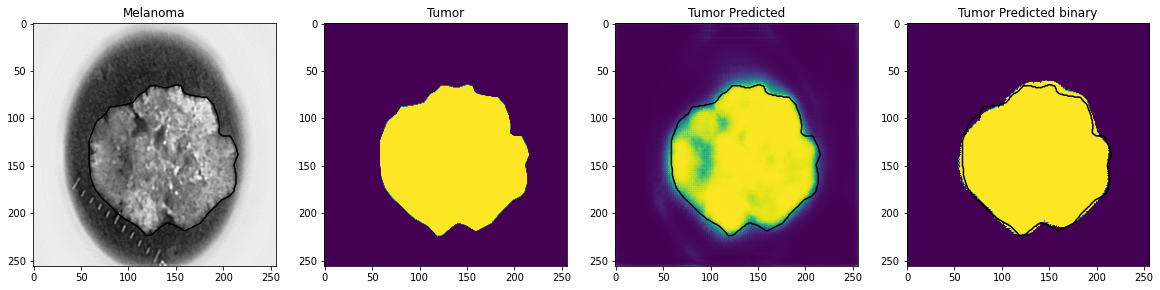

In [75]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=200)

### **Prediction on Test set**

In [76]:
eval_segm = model.predict(X_test,batch_size=16,verbose=1)

63/63 [==============================] - 16s 261ms/step


In [77]:
# Threshold predictions
preds_test_t = (eval_segm > 0.5).astype(np.uint8)


In [98]:
def plot_test(X_test, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X_test))


    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X_test[ix, ..., 0], cmap='Greys')
    ax[0].set_title('Test Image')

    ax[1].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    ax[1].set_title('Tumor Predicted')
    
    ax[2].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    ax[2].set_title('Tumor Predicted binary')

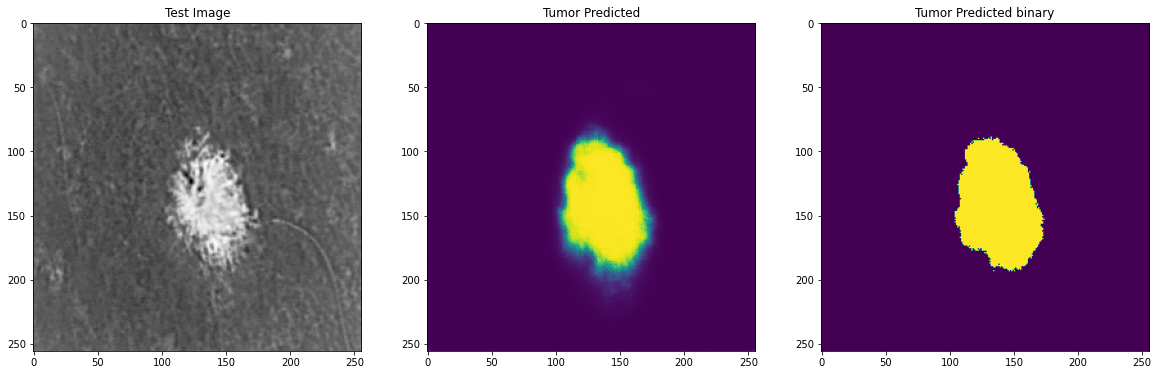

In [102]:
plot_test(X_test, eval_segm, preds_test_t, ix=40)